# Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


# Function that sets up HNC QSP 

### Create and run plasma

In [4]:
name='Al'
Z, A = 13, 27
mi = m_p * A
ρ_gpercc =  2.7 
ni_cc = ρ_gpercc/(mi*AU_to_g)
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU

Te_eV = 1
Ti_eV = 1

ri_AU
Zbar = 3

### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

### Solving

In [5]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='linear')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def best_shift(plasma, guess_c_s_k, ftol=1e-8, set=True):
    
    
    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
    print(sol)
    return sol

### Testing Ashcroft Smoothed
The regular ashcroft potential is 
$$ \beta v^A_{ei} = 
\left\{\begin{array}{ll}
 -\alpha \bar{Z}/R_c &  r<= R_c \\ 
 -\bar{Z}/r & r > R_c
\end{array}\right\}
$$

or in k-space
$$
\beta \tilde{v}^A_{ei} = -\frac{4\pi\bar{Z}}{k^2} \left( \cos(k R_c)(1-\alpha) + \alpha\sin(k R_c)/ k R_c  \right)
$$
We smooth the Ashcroft potential to account for finite electron spread as 
$$
\beta \tilde{v}^{SA}_{ei} = -4\pi\bar{Z}\left( \frac{1}{k^2} - \frac{1}{k^2+1/\Lambda_{ei}^2}  \right) \left( \cos(k R_c)(1-\alpha) + \alpha \sin(k R_c)/ k R_c  \right)
$$
for $\Lambda_{ij} = \sqrt{2\pi \mu_{ij} T_{ij}}$ the inter-particle thermal deBroglie wavelength.
One can verify that setting $R_c=0$ and FTing reduces to the Deutsch potential
$$
\beta v^D = \frac{\beta Z}{r} \left( 1- e^{r/\Lambda_{ei}}   \right)
$$


In [10]:
def make_Ashcroft_βvei(atom, α=1, Rc = 0.4):
    k = atom1.hnc.k_array
    βvei= atom1.hnc.FT_k_2_r(  4*π*atom1.qsp.Γei* (np.cos(k*Rc)*(1-α) + α*np.sin(k*Rc)/(k*Rc)) * (1/k**2 - 1/(k**2 + 1/atom1.qsp.Λei**2)) )
    atom.hnc.βu_r_matrix[0,1] = βvei
    atom.hnc.βu_r_matrix[1,0] = βvei
    atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)


In [12]:
atom1 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'svt'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

atom2 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.11, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

atom3 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,find_βuee=True, 
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':True}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                 qsp_options={'r_c':0.3, 'Te_c_type':'Fermi'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1,'verbose':False, 'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

label1='SVT- Fermi- empty'
label2='SVT- Fermi- continuous'

make_Ashcroft_βvei(atom1, α=0, Rc = 0.4)
make_Ashcroft_βvei(atom2, α=1, Rc = 0.4)
# make_Ashcroft_βvei(atom3, α=1, Rc = 0.4)



Te_in_eV: 1.000
Ti_in_eV: 1.000
Te_in_eV: 1.000
Ti_in_eV: 1.000
Te_in_eV: 1.000
Ti_in_eV: 1.000


#### atom1

In [16]:
c_k_guess = np.loadtxt("../data/dcf_data/Al_1.00e+00eV_rs2.996_svt-hnc-softAshcroft-Rc0p2_c_k_matrix.csv").reshape(2,2,1000)

In [18]:
c_s_k_guess = atom1.hnc.βu_l_k_matrix + c_k_guess
# best_shift(atom1, atom2.hnc.c_s_k_matrix.copy())
atom1.run_hnc(newton=False, c_s_k_guess = c_s_k_guess)#atom2.hnc.c_s_k_matrix.copy())
# solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=50))
# solve_least_squares(atom1, np.linspace(atom1.hnc.k_array[0], atom1.hnc.k_array[-1], num=300), c_s_k_guess = saved_csk_guess)
# solve_least_squares(atom1, np.linspace(atom1.hnc.k_array[0], atom1.hnc.k_array[-1], num=1000))#, c_s_k_guess = atom2.hnc.c_s_k_matrix.copy())

0: Initial condition Total Error: 4.753e-01
Starting Ng loop, using best index so far:  499
|d_n|^2 =  [0.31447169285556315, 0.31650082885830627, 0.31854289951113246]
 αs:  [ 11633.25842171 -23036.84292143  11404.58449973]
|d_n|^2 =  [0.0010626219358854901, 0.31447169285556315, 0.31650082885830627]
 αs:  [  1.54775767 -84.87412526  84.32636759]
|d_n|^2 =  [0.016353403855518613, 0.0010626219358854901, 0.31447169285556315]
 αs:  [6.39871506e-02 9.35771555e-01 2.41294132e-04]
|d_n|^2 =  [5.926572830919023e-05, 0.016353403855518613, 0.0010626219358854901]
 αs:  [0.96609935 0.00524553 0.02865512]
|d_n|^2 =  [2.6969168270200215e-05, 5.926572830919023e-05, 0.016353403855518613]
 αs:  [ 8.30770405e-01  1.69945899e-01 -7.16304248e-04]
|d_n|^2 =  [1.4910911520242247e-05, 2.6969168270200215e-05, 5.926572830919023e-05]
 αs:  [ 2.38285445 -1.33543971 -0.04741474]
|d_n|^2 =  [1.3802962617459947e-05, 1.4910911520242247e-05, 2.6969168270200215e-05]
 αs:  [ 4.3196249  -2.53580057 -0.78382433]
|d_n|^2 =

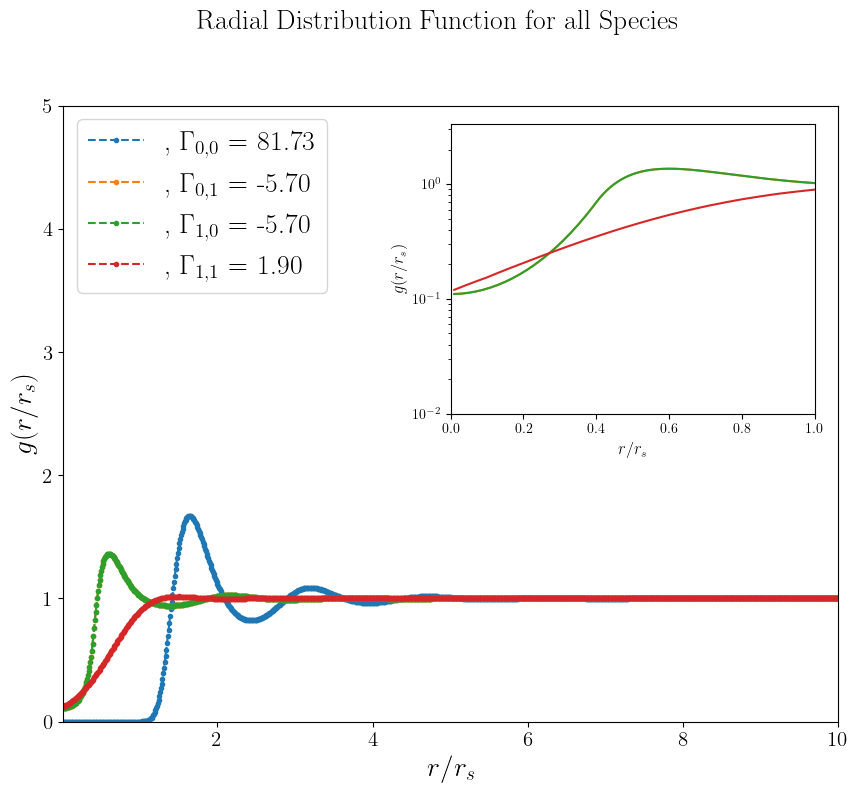

In [19]:
atom1.hnc.plot_g_all_species()

#### atom2

In [25]:
atom2.run_hnc(newton=False)#, c_s_k_guess = atom1.hnc.c_s_k_matrix.copy())
# solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=400))#, c_s_k_guess = atom1.hnc.c_s_k_matrix.copy())
# solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=1000))

0: Initial condition Total Error: 1.280e+01
Starting Ng loop, using best index so far:  499
|d_n|^2 =  [0.3417889990928105, 0.34575323587465373, 0.3497626903691398]
 αs:  [ 3810.45327996 -7490.70117578  3681.24789582]
|d_n|^2 =  [0.0003476818328506344, 0.3417889990928105, 0.34575323587465373]
 αs:  [ 0.91581363  7.29333205 -7.20914569]
|d_n|^2 =  [0.0014715192381749476, 0.0003476818328506344, 0.3417889990928105]
 αs:  [ 1.94503835e-01  8.05564957e-01 -6.87914037e-05]
|d_n|^2 =  [7.941197759335547e-05, 0.0014715192381749476, 0.0003476818328506344]
 αs:  [0.78297269 0.00991752 0.20710978]
|d_n|^2 =  [8.488400722458723e-05, 7.941197759335547e-05, 0.0014715192381749476]
 αs:  [ 0.39117995  0.65849391 -0.04967386]
|d_n|^2 =  [5.095905476981742e-05, 8.488400722458723e-05, 7.941197759335547e-05]
 αs:  [ 1.48462137 -1.59519502  1.11057366]
|d_n|^2 =  [4.5037714507405996e-05, 5.095905476981742e-05, 8.488400722458723e-05]
 αs:  [ 2.36187339 -1.26025211 -0.10162128]
|d_n|^2 =  [5.1269619003065365

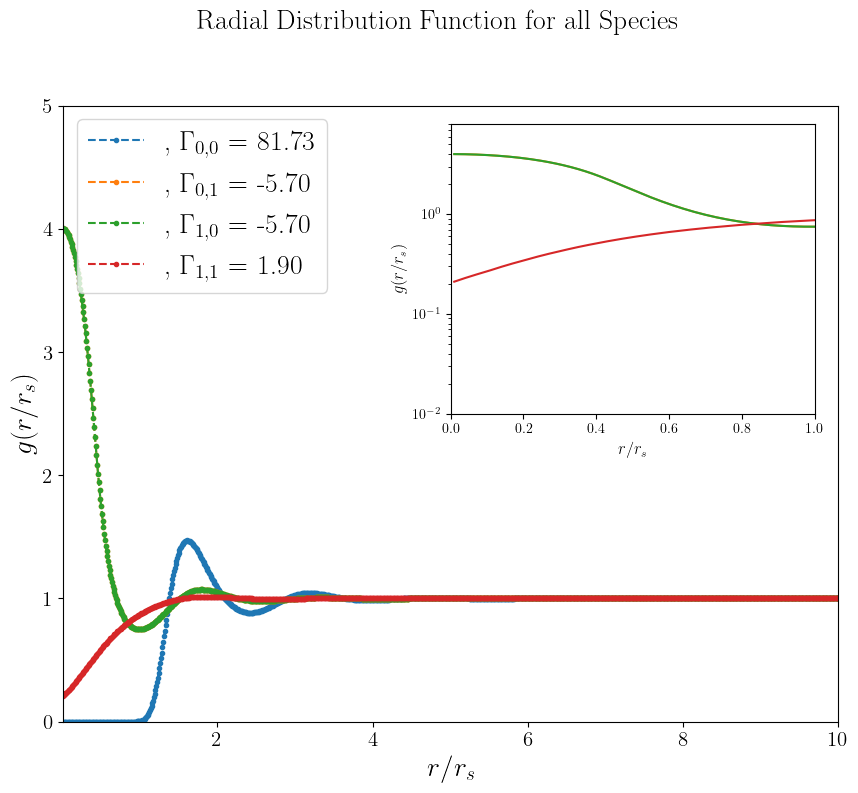

In [26]:
atom2.hnc.plot_g_all_species()

#### atom3

In [69]:
# atom3.run_hnc(newton=False, c_s_k_guess = atom2.hnc.c_s_k_matrix.copy())
solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=200))
solve_least_squares(atom3, np.linspace(atom3.hnc.k_array[0], atom3.hnc.k_array[-1], num=400))#, c_s_k_guess = atom2.hnc.c_s_k_matrix.copy())

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9819e+01                                    7.84e+02    
       1              4         9.8074e+00      2.00e+01       9.99e+00       3.07e+02    
       2              5         1.0408e+00      8.77e+00       9.99e+00       7.45e+01    
       3              6         2.3807e-02      1.02e+00       3.70e+00       8.58e+00    
       4              7         3.8316e-04      2.34e-02       1.46e+00       8.50e-01    
       5              8         3.1390e-05      3.52e-04       7.00e-01       3.02e-01    
       6              9         6.4787e-07      3.07e-05       1.92e-01       4.14e-02    
       7             10         5.0581e-10      6.47e-07       1.41e-02       3.31e-04    
       8             11         2.6633e-13      5.06e-10       5.47e-04       2.06e-06    
       9             12         1.6298e-15      2.65e-13       1.01e-05       4.66e-07    


KeyboardInterrupt



In [102]:
# solve_least_squares(atom3, np.linspace(atom3.hnc.k_array[0], atom3.hnc.k_array[-1], num=1000), c_s_k_guess = atom2.hnc.c_s_k_matrix.copy())

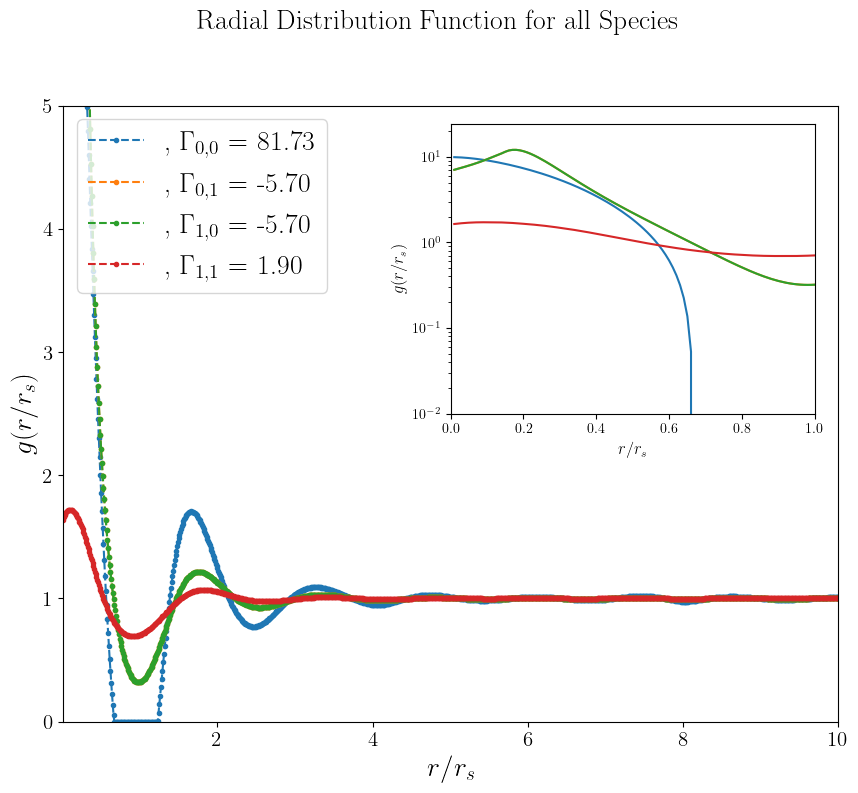

In [70]:
atom3.hnc.plot_g_all_species()

In [155]:
atom4.run_hnc(newton=False)#, c_s_k_guess = atom2.hnc.c_s_k_matrix.copy())

0: Initial condition Total Error: 9.429e+00
1: Change in c_r: 3.060e-02, HNC Error: 1.067e+00, Total Error: 8.851e+00
2: Change in c_r: 3.051e-02, HNC Error: 7.570e-01, Total Error: 8.359e+00
3: Change in c_r: 3.048e-02, HNC Error: 5.687e-01, Total Error: 7.912e+00
4: Change in c_r: 3.048e-02, HNC Error: 4.438e-01, Total Error: 7.498e+00
5: Change in c_r: 3.051e-02, HNC Error: 3.564e-01, Total Error: 7.112e+00
6: Change in c_r: 3.057e-02, HNC Error: 2.930e-01, Total Error: 6.752e+00
7: Change in c_r: 3.065e-02, HNC Error: 2.459e-01, Total Error: 6.414e+00
8: Change in c_r: 3.076e-02, HNC Error: 2.105e-01, Total Error: 6.098e+00
9: Change in c_r: 3.087e-02, HNC Error: 1.836e-01, Total Error: 5.801e+00
10: Change in c_r: 3.100e-02, HNC Error: 1.632e-01, Total Error: 5.523e+00
11: Change in c_r: 3.114e-02, HNC Error: 1.478e-01, Total Error: 5.261e+00
12: Change in c_r: 3.127e-02, HNC Error: 1.363e-01, Total Error: 5.015e+00
13: Change in c_r: 3.141e-02, HNC Error: 1.279e-01, Total Error: 

In [157]:
# solve_least_squares(atom4, np.linspace(atom4.hnc.k_array[0], atom4.hnc.k_array[-1], num=300), c_s_k_guess = atom3.hnc.c_s_k_matrix.copy())
# solve_least_squares(atom4, np.linspace(atom4.hnc.k_array[0], atom4.hnc.k_array[-1], num=200))#, c_s_k_guess = atom3.hnc.c_s_k_matrix.copy())

In [146]:
# atom4_saved_csk = atom4.hnc.c_s_k_matrix.copy()

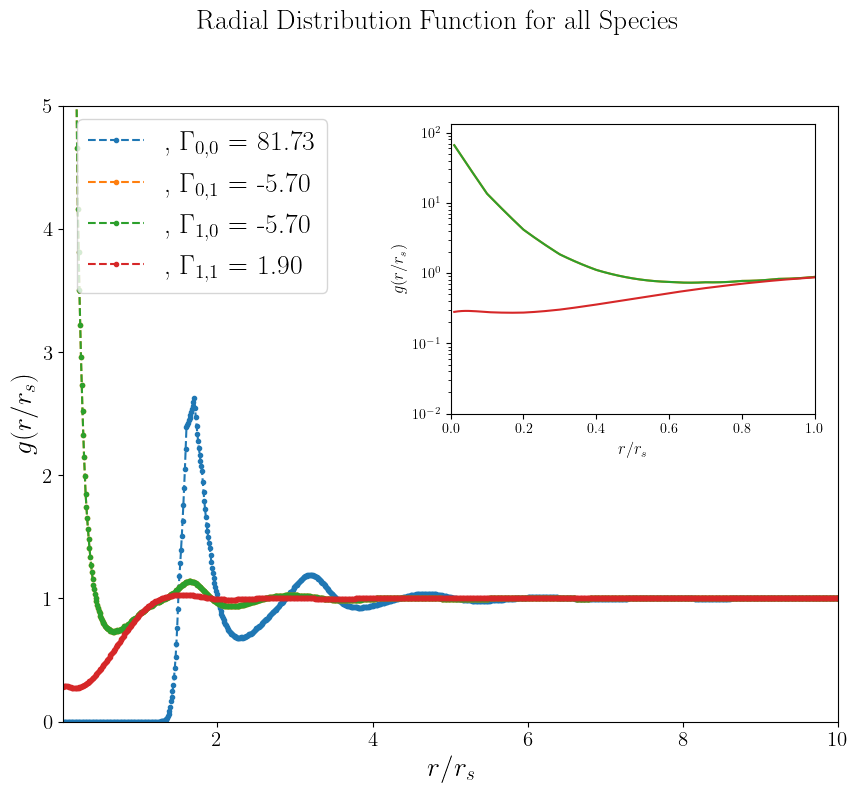

In [158]:
atom4.hnc.plot_g_all_species()

In [165]:
# atom5.run_hnc(newton=False)#, c_s_k_guess = atom4.hnc.c_s_k_matrix.copy())
# solve_least_squares(atom5, np.linspace(atom5.hnc.k_array[0], atom5.hnc.k_array[-1], num=400))#, c_s_k_guess = atom4.hnc.c_s_k_matrix.copy())
solve_least_squares(atom5, np.linspace(atom5.hnc.k_array[0], atom5.hnc.k_array[-1], num=1000))#, c_s_k_guess = atom4.hnc.c_s_k_matrix.copy())

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8520e+06                                    1.32e+08    
       1              7         6.9840e+05      1.15e+06       9.42e-01       7.58e+07    
       2              8         1.5181e+05      5.47e+05       9.42e-01       1.74e+07    
       3              9         1.0292e+05      4.89e+04       1.88e+00       9.78e+06    
       4             10         6.1651e+04      4.13e+04       1.88e+00       8.01e+06    



KeyboardInterrupt



In [168]:
# atom5_save_csk = atom5.hnc.c_s_k_matrix.copy()

In [ ]:
atom5.hnc.plot_g_all_species()

### Plot and Comparison to QMD

In [22]:
ocp =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

ocp.run_ocp_hnc()

Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 2.804e+01


/home/zach/plasma/hnc/hnc/PIE.py:163: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


Starting Ng loop, using best index so far:  499
|d_n|^2 =  [1.429463516757614, 1.4389924536307688, 1.4485827183519493]
 αs:  [ 10999.29844727 -21777.27251725  10778.97406998]
|d_n|^2 =  [0.016696524496966292, 1.429463516757614, 1.4389924536307688]
 αs:  [  0.76678787  34.57331934 -34.34010722]
|d_n|^2 =  [0.16031600941248397, 0.016696524496966292, 1.429463516757614]
 αs:  [ 0.08674555  0.91501462 -0.00176017]
|d_n|^2 =  [0.010411035204568432, 0.16031600941248397, 0.016696524496966292]
 αs:  [ 0.92824918 -0.04917453  0.12092535]
|d_n|^2 =  [0.002717469128109417, 0.010411035204568432, 0.16031600941248397]
 αs:  [ 1.14901769 -0.17587277  0.02685508]
|d_n|^2 =  [0.0030259110709960767, 0.002717469128109417, 0.010411035204568432]
 αs:  [ 3.16162858 -2.44851363  0.28688505]
|d_n|^2 =  [0.0029597503571182167, 0.0030259110709960767, 0.002717469128109417]
 αs:  [  7.35157717 -12.26598489   5.91440773]
|d_n|^2 =  [0.0006373182839867361, 0.0029597503571182167, 0.0030259110709960767]
 αs:  [ 0.8359

In [35]:
MD_data = read_csv("/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt",  header=1)
MD_data.columns=['r','g']
MD_data;

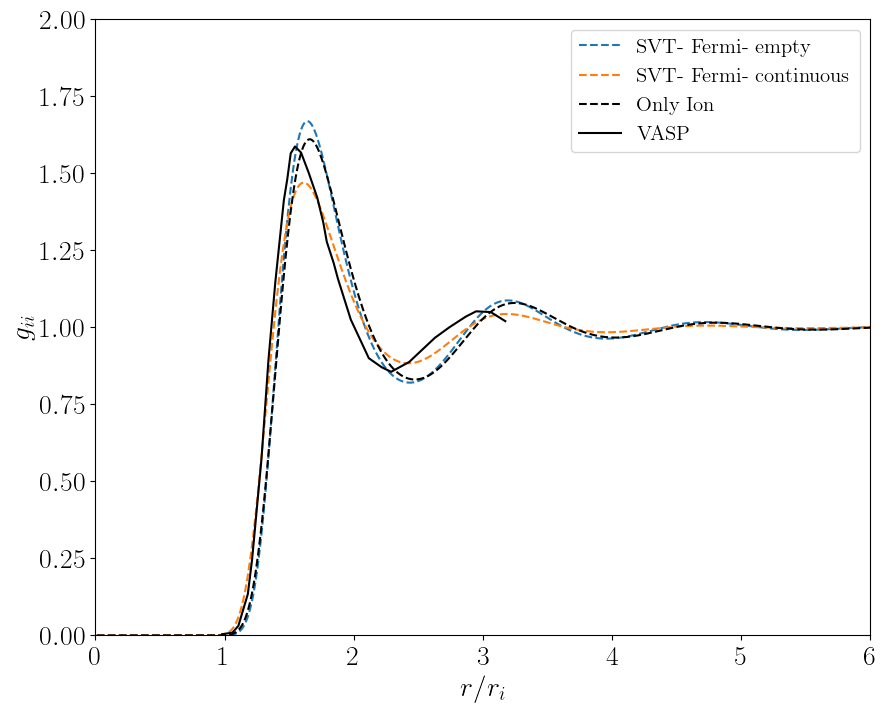

In [36]:
fig, ax = plt.subplots(figsize=(10,8))

# Model Comparison
ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,0]+1,'--', label=label1)
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[0,0]+1,'--', label=label2)
# ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[0,0]+1,'--', label='SVT- DMC')

# OCP
ax.plot(ocp.ocp_hnc.r_array, ocp.ocp_hnc.h_r_matrix[0,0]+1,'k--', label='Only Ion')

# Data
ax.plot(MD_data['r'], MD_data['g'], 'k',label='VASP')

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(0,6)
ax.set_ylim(0,2)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

### Effective Potential

In [62]:
Luke_pair

,i,r[A],u[eV],F[eV/A]
0,1,0.010000,2.574324e+10,1.890979e+12
1,2,0.023242,7.026795e+08,9.681522e+11
2,3,0.036484,1.024740e+08,2.550060e+10
3,4,0.049726,2.731567e+07,3.492874e+09
4,5,0.062968,9.967963e+06,8.647882e+08
...,...,...,...,...
600,601,7.947097,7.557507e-06,2.252162e-04
601,602,7.960323,4.930165e-06,1.712737e-04
602,603,7.973549,3.026975e-06,1.157206e-04
603,604,7.986774,1.869355e-06,5.853508e-05


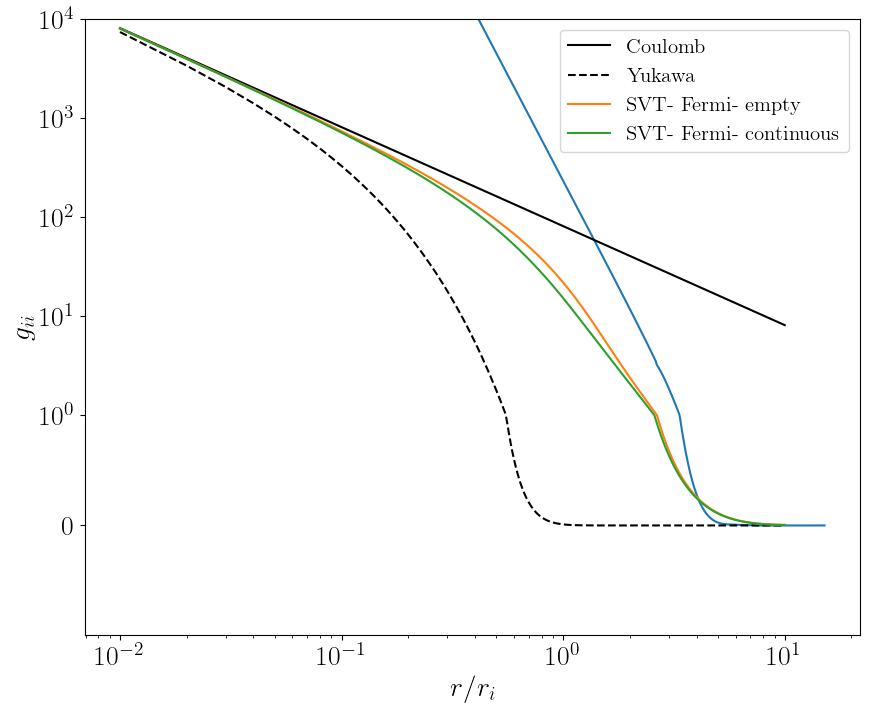

In [69]:
Luke_pair = read_csv("../data/Al_T1_tab.lammps.PAIR", delim_whitespace=True, header=4)


atom1.hnc.invert_HNC_OZ([1])
atom2.hnc.invert_HNC_OZ([1])
# atom3.hnc.invert_HNC_OZ([1])

fig, ax = plt.subplots(figsize=(10,8))

# LUKE Potfit VASP
ax.plot(Luke_pair['r[A]']*Angstrom_to_AU, atom1.qsp.βie_c*Luke_pair['u[eV]']*eV_to_AU)

# Coulomb and Yukawa
ax.plot(atom1.hnc.r_array, atom1.hnc.βu_r_matrix[0,0],'k-', label='Coulomb')
ax.plot(atom1.hnc.r_array, atom1.qsp.βv_Yukawa(atom1.hnc.r_array),'k--', label='Yukawa')

# Models
ax.plot(atom1.hnc.r_array, atom1.hnc.βueff_r_matrix[0,0],'-', label=label1)
ax.plot(atom2.hnc.r_array, atom2.hnc.βueff_r_matrix[0,0],'-', label=label2)
# ax.plot(atom3.hnc.r_array, atom3.hnc.βueff_r_matrix[0,0],'-', label='SVT- DMC')

# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
# ax.set_xlim(None,6)
ax.set_ylim(-1,1e4)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=1)
ax.set_xscale('log')

ax.legend(fontsize=15)

### Large r oscillations

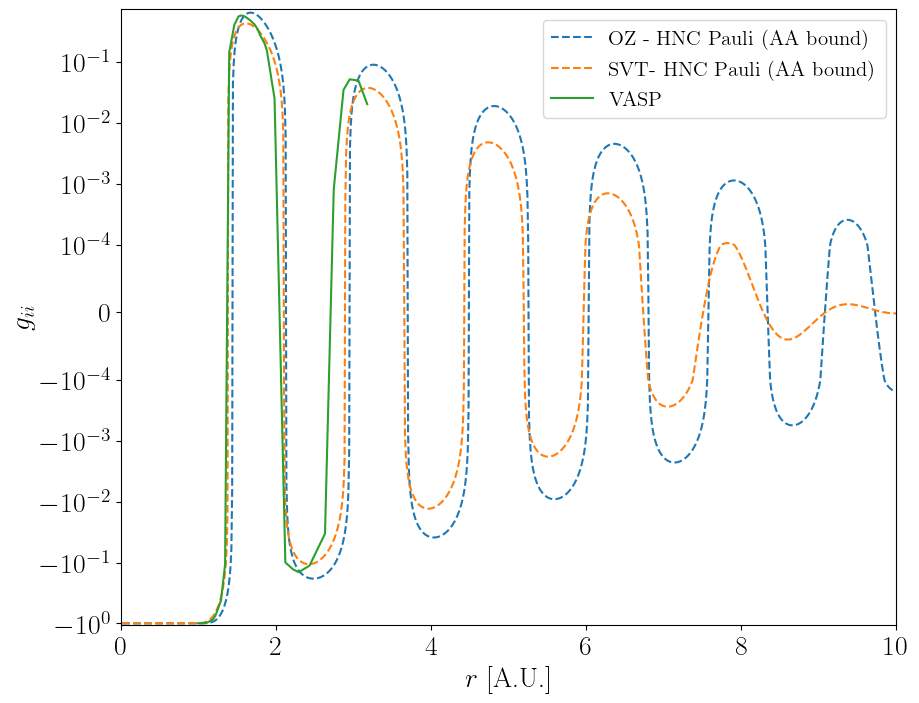

In [60]:
# AA_data = read_csv("/home/zach/plasma/atoMEC/examples/density.csv", delim_whitespace=True, header=0)

fig, ax = plt.subplots(figsize=(10,8))
# nf_0 = Zbar/(4/3*np.pi*atom.qsp.ri**3)
# ax.plot(AA_data['r[a_0]'], np.array(AA_data['n[unbound]'])/nf_0,'k.' ,label="AA" )
# ax.plot(atom_2e.hnc.r_array*atom_2e.qsp.ri, atom_2e.hnc.h_r_matrix[0,0]+1,'--', label='2 electron SVT ')
# ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,0]+1,'--', label='Ashcroft Pseudopotential')
ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,0],'--', label='OZ - HNC Pauli (AA bound)')
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[0,0],'--', label='SVT- HNC Pauli (AA bound)')
# ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[0,0],'--', label='SVT- HNC Pauli (pointlike bound)')
# ax.plot(atom4.hnc.r_array, atom4.hnc.h_r_matrix[0,0]+1,'--', label='OZ- HNC Pauli (pointlike bound, core-core)')
# ax.plot(atom5.hnc.r_array, atom5.hnc.h_r_matrix[0,0]+1,'--', label='SVT- HNC Pauli (pointlike bound, core-core)')
# ax.plot(atom_long.hnc.r_array, atom_long.hnc.h_r_matrix[0,0]+1,'-.', label='1 electron SVT-long ')
# ax.plot(atom_oz.hnc.r_array, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='1 electron OZ ')
# ax.plot(atom.hnc.r_array, atom_oz.onlyion_hnc.h_r_matrix[0,0]+1,'--', label='Only Ion')
ax.plot(MD_data['r'], MD_data['g']-1, label='VASP')

# ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')

ax.set_xlim(0,10)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=0.0001)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

In [23]:
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_oz-hnc-Pauli-bound-dist_c_k_matrix.csv", atom1.hnc.c_k_matrix.reshape(4,atom1.hnc.N_bins))
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-softAshcroft-Rc0p2_c_k_matrix.csv", atom2.hnc.c_k_matrix.reshape(4,atom2.hnc.N_bins))
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-Pauli-bound-point_c_k_matrix.csv", atom3.hnc.c_k_matrix.reshape(4,atom3.hnc.N_bins))

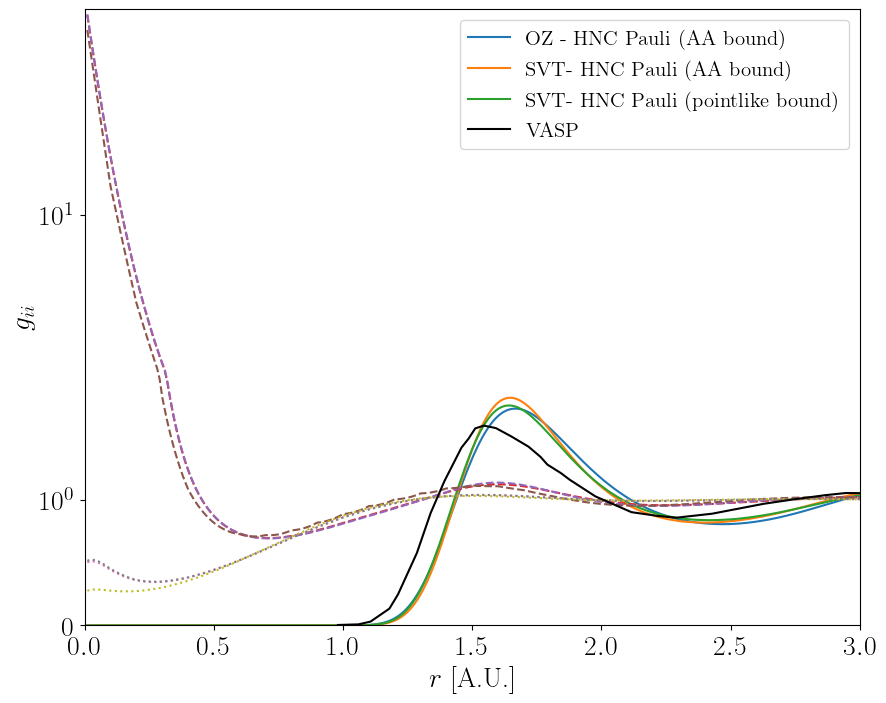

In [213]:
# AA_data = read_csv("/home/zach/plasma/atoMEC/examples/density.csv", delim_whitespace=True, header=0)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,0]+1,'-', label='OZ - HNC Pauli (AA bound)')
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[0,0]+1,'-', label='SVT- HNC Pauli (AA bound)')
ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[0,0]+1,'-', label='SVT- HNC Pauli (pointlike bound)')

ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,1]+1,'--')
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[0,1]+1,'--')
ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[0,1]+1,'--')


ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[1,1]+1,':')
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[1,1]+1,':')
ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[1,1]+1,':')

ax.plot(MD_data['r'], MD_data['g'], 'k-',label='VASP')

# ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')

ax.set_xlim(0,3)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=2)
ax.set_ylim(0,None)
# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

### Bound and Free state Examination

(0.0, 15.0)

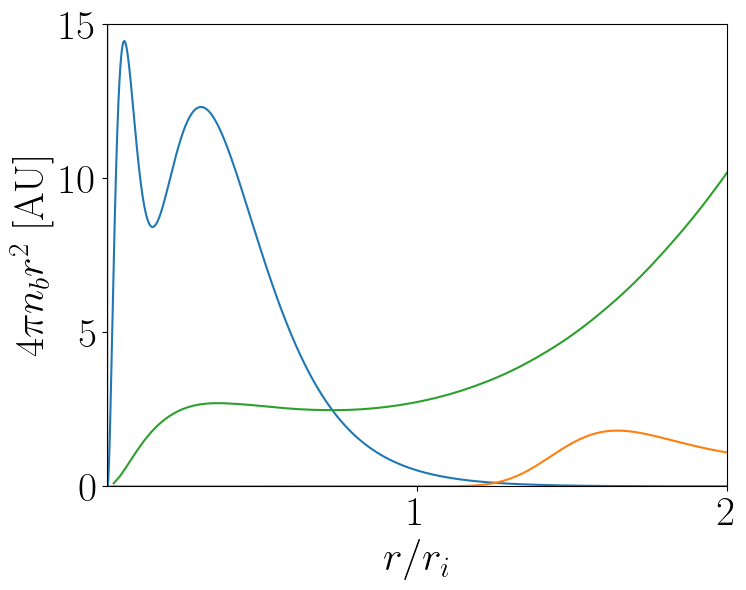

In [58]:
bound_file = "/home/zach/plasma/hnc/TCCW/data/Al_rs_3.000_T_1.000e+00eV.csv"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = np.array(AA_data['r[a_0]'])
AA_nb_AU_full = np.array(AA_data['n(bound)'])

# Only use some values for speed
min_r_to_use = 0.2*atom.hnc.r_array[0]*atom.qsp.ri # in AU
indcs = np.where(AA_r_AU_full > min_r_to_use)
AA_r_AU = AA_r_AU_full[indcs]
AA_nb_AU = AA_nb_AU_full[indcs]

# Plot bound states
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(AA_r_AU_full/atom.qsp.ri*2, 4*π*AA_nb_AU_full*AA_r_AU_full**2)
# ax.plot(AA_r_AU_full/atom.qsp.ri, AA_nb_AU_full)
ax.plot(atom2.hnc.r_array, (atom2.hnc.h_r_matrix[0,0]+1) )
ax.plot(atom2.hnc.r_array*2, 4*π*atom2.hnc.r_array**2*(atom2.hnc.h_r_matrix[0,1]+1) )
# ax.plot(atom2.hnc.r_array, 4*π*(atom2.hnc.r_array*atom2.qsp.ri)**2*(atom2.hnc.h_r_matrix[0,1]+1)*(atom2.hnc.rho[1]/atom2.qsp.ri**3),'--', label='HNC bound Pauli')
ax.axvspan(AA_r_AU_full[0]/atom.qsp.ri, min_r_to_use/atom.qsp.ri, color='k', alpha=0.1)
ax.set_xlabel(r'$r/r_i$')
ax.set_ylabel(r'$4 \pi n_b r^2$ [AU]')
# ax.set_xscale('log')
ax.set_xlim(np.min(AA_r_AU_full/atom.qsp.ri), 2*np.max(AA_r_AU_full/atom.qsp.ri))
ax.set_ylim(0, 15)


## Born Green Viscocity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


In [ ]:
from scipy.integrate import simpson

def get_ηBG(plasma):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    ##
    fig, ax = plt.subplots()
    ax.plot(r_array, dφdr*r_array**4)
    ###
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

η_SI = get_ηBG(atom2)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
print(f"SI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
print(f"CGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")

In [ ]:
Zbar_list  = np.linspace(3,Zbar, num=100)
# Zbar_list = [1,3]
atom_list= []
for i, Zbar_i in enumerate(Zbar_list):
    print("Zbar = {0:.3f}".format( Zbar_i ))
    
    atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar_i, 
                 βu_options = {'add_bridge':True}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':10},
                 hnc_solve_options={'alpha_Picard':0.5})
    if i>=1:
        Z2_matrix = [[Zbar_list[i]]]
        guess_2 = 
        c_s_k_guess = atom_list[-1].hnc.c_s_k_matrix
        c_s_k_guess[0,0] *= (Zbar_list[i]/Zbar_list[i-1])**2 
        c_s_k_guess[0,1] *= (Zbar_list[i]/Zbar_list[i-1])**1 
        c_s_k_guess[1,0] *= (Zbar_list[i]/Zbar_list[i-1])**1
#         c_s_k_guess[0,0] *= 0
    else:
        c_s_k_guess *=0
    atom.run_hnc(c_s_k_guess=c_s_k_guess)
    atom_list.append( atom )

In [ ]:
fig, axs = plt.subplots(2, 2, facecolor='w', figsize=(10,8) )

atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix-atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 
atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix/atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 

for i in range(2):
    for j in range(2):
        for k, atom in enumerate(atom_list):
            color = plt.cm.viridis(k/len(atom_list))
            Z_factor = (Zbar_list[0]/Zbar_list[k])**-1
            axs[i, j].plot(atom.hnc.r_array, atom.hnc.c_s_k_matrix[i,j], '--',label= "Zbar", color= color)
            axs[i, j].plot(atom.hnc.r_array, Z_factor*atom_list[0].hnc.c_s_k_matrix[i,j],'.', label= "Zbar", color= color)
#             axs[i, j].plot(atom.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=2")
#             axs[i, j].plot(atom.hnc.r_array, atom6.hnc.c_s_k_matrix[i,j], label= "Zbar=6")
#         axs[i, j].plot(atom2.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j]-atom1.hnc.c_s_k_matrix[i,j], label= "Zbar=2/1")
#         axs[i, j].plot(atom2.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j]-atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=3/2")
#         axs[i, j].plot(atom2.hnc.r_array, atom3_guess[i,j] , 'k--', label= "Zbar=3 (guess)")
        
#         axs[i, j].plot(atom3.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j],'k', label= "Zbar=3")
#         axs[i, j].plot(atom100.hnc.r_array, atom80.hnc.c_s_k_matrix[i,j]-100/80*atom100.hnc.c_s_k_matrix[i,j], label= "80/100 eV")
#         axs[i, j].plot(atom100.hnc.r_array, atom60.hnc.c_s_k_matrix[i,j], label= "60 eV")
         
#         axs[i, j].plot(atom100.hnc.r_array, T_rescale[i,j]*atom100.hnc.c_s_k_matrix[i,j], label= "rescaled 100 eV")
        
        axs[i,j].set_xscale('log')
#         axs[i, j].set_yscale('symlog', linthresh=0.1)
#         axs[i, j].legend()
        
plt.tight_layout()

In [ ]:
atom.get_cp(ε_derivative=1e-6, ε_table=1e-1, N_table= 2 )

In [ ]:
fig, ax = plt.subplots()

# ax.plot(atom.hnc.r_array, atom.hnc.βueff_r_matrix[0,0])
ax.plot(atom.hnc.r_array, atom.hnc.h_r_matrix[0,0]+1)
# ax.set_yscale('symlog', linthresh=1)

###### Hydrogen H1

c_p = 1.667e+08 [J/m^3/K] = 1.667e+09 [erg/cc/K]


c_p^ideal = 2.064e+07 [J/m^3/K] = 2.064e+08 [erg/cc/K]

c_v = 1.229e+08 [J/m^3/K] = 1.229e+09 [erg/cc/K]


γ = cp/cv = 1.357e+00

###### Aluminum Al1

c_p = 5.560e+06 [J/m^3/K] = 5.560e+07 [erg/cc/K]

c_p^ideal = 2.081e+06 [J/m^3/K] = 2.081e+07 [erg/cc/K]

c_v = 3.559e+06 [J/m^3/K] = 3.559e+07 [erg/cc/K]

c_p_over_nkB = 6.678

c_v_over_nkB = 4.275

γ = cp/cv = 1.562e+00

##### Carbon C1

c_p = 1.005e+09 [J/m^3/K] = 1.005e+10 [erg/cc/K]

c_p^ideal = 1.729e+07 [J/m^3/K] = 1.729e+08 [erg/cc/K]

c_v = 7.410e+08 [J/m^3/K] = 7.410e+09 [erg/cc/K]

γ = cp/cv = 1.357e+00

##### Copper Cu1
c_p = 6.829e+07 [J/m^3/K] = 6.829e+08 [erg/cc/K]

c_p^ideal = 2.930e+06 [J/m^3/K] = 2.930e+07 [erg/cc/K]

c_v = 4.460e+07 [J/m^3/K] = 4.460e+08 [erg/cc/K]

γ = cp/cv = 1.531e+00

In [ ]:
# Compare to Ichimaru
n_AU = ni_cc * (1e2*aB)**3
E_over_nkBT = atom.U/( Te*N )
P_over_nkBT = atom.P/(Te*n_AU)
c_p_over_nkB = C_p_AU/N #c_p_SI_vol/k_B/(ni_cc*1e6)
E_over_nkBT, P_over_nkBT, c_p_over_nkB  

In [ ]:
# 2x2
#(16.078004224152146, 7.958852940677674, 20.391840227664225)
# 3x3
#(17.29156071613095, 9.41653222069282, 19.954770080816058)
# 4x4
#(17.29156071613095, 9.41653222069282, 20.31577883096223)
# 6x6
#(17.29156071613095, 9.41653222069282, 20.341775951597302)



In [ ]:
#cp units are J/K/m^3

In [ ]:
c_p_SI_vol *J_to_erg*1e-6 # from J/K/m^3 to erg/K/cc

In [ ]:
(c_p_over_nkB*ni_cc * k_B*1e6)/1e8 # in erg/

In [ ]:
# Ideal
# (1.503495387998133, 1.0020009999999997, 2.5033223241241656)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom = atom_highres

In [ ]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
luke_r

In [ ]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, 5)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()